In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./hf_transformers/")

In [3]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import T5Config
from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from transformers import set_seed

In [4]:
from datetime import datetime
import argparse
import os

In [5]:
import torch

from data_reader import GetDataAsPython
from prepare_data import create_data
from prepare_data import create_dataset
from prepare_data import extract_warning_types
from utils import boolean_string
from utils import get_current_time
import csv
import numpy as np
import random


In [6]:
local = True

if local:
    storage_directory = './storage/'
    base_model = f'./{storage_directory}/checkpoint-37375'
    batch_size = 16
    codebert_address = "microsoft/codebert-base"
else:
    storage_directory = '/scratch/arminz/'
    batch_size = 64
    # base_model = f'/{storage_directory}/t5-small_global_repo-based_03-11-2021_15-28-40/checkpoint-37375/'
    base_model = f'{storage_directory}/checkpoint-37375'
    codebert_address = "/home/arminz/codebert-base"


In [ ]:
import codebert_utils
codebert_utils.load(codebert_address)

In [ ]:
exec_number = random.randint(0, 1000)

# parser = argparse.ArgumentParser()
# parser.add_argument("-a", "--append", type=int, required=True)
# parser.add_argument("-rp", "--repo_percent", type=float, required=True)
# parser.add_argument("-r", "--repo", type=str, required=True)

# args = parser.parse_args()
append = 0#args.append
repo = '/data/all/data/girder/girder' #,/data/all/data/request/request'#, args.repo
repo_percent = 0.65 # args.repo_percent


In [9]:
data = GetDataAsPython(f"{storage_directory}/data_and_models/data/data_autofix_tracking_repo_specific_final.json")
data_eslint = GetDataAsPython(f"{storage_directory}/data_and_models/data/data_autofix_tracking_eslint_final.json")
data += data_eslint
len(data)

104804

In [10]:
data[0].repo

'/data/all/data/xpl/useless'

In [11]:
name = 'added'

In [12]:
all_warning_types = extract_warning_types(data)

# In[16]:


(repo_train_inputs, repo_train_labels, repo_val_inputs, repo_val_labels, repo_test_inputs, repo_test_labels,
 repo_train_info, repo_val_info, repo_test_info,) = create_data(data, all_warning_types, include_warning=True,
                                                                design='repo-based-included', select_repo=repo)

# In[17]:


(general_train_inputs, general_train_labels, general_val_inputs, general_val_labels, general_test_inputs,
 general_test_labels, general_train_info, general_val_info, general_test_info,) = create_data(data, all_warning_types,
                                                                                              include_warning=True,
                                                                                              design='repo-based')

splitting by : repo-based-included
train size: 37
val size: 14
test size: 52
splitting by : repo-based
train size: 75087
val size: 25055
test size: 2383


In [13]:
repo_vecs = np.array([codebert_utils.code_to_vec(item) for item in repo_train_inputs])

In [14]:
from sklearn.neighbors import NearestNeighbors

In [23]:
general_vecs = np.load('general_arr_all.npy')

general_vecs.shape




(75087, 768)

In [22]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(repo_vecs)

In [24]:
distances, indices = nbrs.kneighbors(general_vecs)

In [25]:
repo_nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(repo_vecs)
repo_distances, index = repo_nbrs.kneighbors(repo_vecs)

In [26]:
threshold = sorted(distances)[int(append * 5 / 4)]
print('threshold:', threshold, 'append:', append, int(append * 5 / 4))


threshold: [0.] append: 0 0


In [27]:
selected = (distances < threshold)

In [28]:
assert selected.sum() == int(append * 5 / 4)

In [29]:
samples = int(repo_percent * len(repo_train_inputs))
print(f'all repo samples: {len(repo_train_inputs)}\ntrain samples of repo: {samples} ({repo_percent})')

all repo samples: 37
train samples of repo: 24 (0.65)


In [30]:
assert len(distances) == len(general_train_inputs)

In [31]:
filtered_general_inputs = list()
filtered_general_labels = list()
filtered_general_info = list()
for ind in range(len(general_train_inputs)):
    if selected[ind]:
        filtered_general_inputs.append(general_train_inputs[ind])
        filtered_general_labels.append(general_train_labels[ind])
        filtered_general_info.append(general_train_info[ind])

In [32]:
selected.shape

(75087, 1)

In [34]:
if selected.any():
    filtered_general_distances, _ = nbrs.kneighbors(general_vecs[selected[:, 0]])
    filtered_general_distances.shape

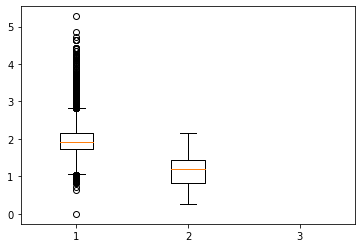

In [35]:
from matplotlib import pyplot as plt
if selected.any():
    plt.boxplot([distances.squeeze(), repo_distances[:, 1], filtered_general_distances.squeeze()])
else:
    plt.boxplot([distances.squeeze(), repo_distances[:, 1], []])
    

In [36]:
print(len(filtered_general_inputs))
assert len(filtered_general_inputs) == int(append * 5 / 4)

0


In [37]:
validation_point = append
print(validation_point)

0


In [38]:
added_inputs_train = filtered_general_inputs[:validation_point]
added_labels_train = filtered_general_labels[:validation_point]
added_info_train = filtered_general_info[:validation_point]

In [39]:
added_inputs_val = filtered_general_inputs[validation_point:]
added_labels_val = filtered_general_labels[validation_point:]
added_info_val = filtered_general_info[validation_point:]

In [40]:
print(len(repo_train_inputs), len(added_inputs_train))

37 0


In [41]:
assert len(added_inputs_train) == append

In [42]:
added_inputs_train += repo_train_inputs[:samples]
added_labels_train += repo_train_labels[:samples]
added_info_train += repo_train_info[:samples]


In [43]:
added_inputs_val += repo_val_inputs
added_labels_val += repo_val_labels
added_info_val += repo_val_info

In [44]:
print('added inputs train', len(added_inputs_train))
print('added inputs val', len(added_inputs_val))


added inputs train 24
added inputs val 14


In [45]:
print('repo val inputs', len(repo_val_inputs))

repo val inputs 14


In [46]:
assert len(added_inputs_train) == append + samples

In [47]:
tokenizer = T5Tokenizer.from_pretrained(base_model)

# In[48]:


train_dataset = create_dataset(added_inputs_train, added_labels_train, tokenizer, pad_truncate=True, max_length=128)
val_dataset = create_dataset(added_inputs_val, added_labels_val, tokenizer, pad_truncate=True)
test_dataset = create_dataset(repo_val_inputs, repo_val_labels, tokenizer, pad_truncate=True)

# In[49]:


now = datetime.now()
test_result_directory = f'{storage_directory}/fine-tune-result'
full_name = f'{name}_{exec_number}_{repo.rsplit("/", 1)[1][-20:]}_{repo_percent}_{samples}_{append}'
model_directory = f'{storage_directory}/tmp/{full_name}'
model_directory

/home/armin/TFix/env/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:185: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


'./storage//tmp/added_605_girder_0.65_24_0'

In [48]:
len(repo_test_inputs)

52

In [49]:
lr = 4e-3
ws = 300
wd = 0.4

In [50]:
tokenizer = T5Tokenizer.from_pretrained(base_model)
model = T5ForConditionalGeneration.from_pretrained(base_model)
model.resize_token_embeddings(len(tokenizer))

Embedding(32104, 512)

In [51]:
from transformers import EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir=model_directory,
    num_train_epochs=15,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=ws,
    weight_decay=wd,
    logging_dir=model_directory,
    logging_steps=100,
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,
    eval_accumulation_steps=1,  # set this lower, if testing or validation crashes
    disable_tqdm=False,
    predict_with_generate=True,  # never set this to false.
    seed=42,  # default value
)


In [52]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=[torch.optim.Adam(params=model.parameters(), lr=lr), None],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
    #     compute_metrics=compute_metrics
)

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,No log,0.061004,0.033100,422.600000
2,No log,0.055694,0.033800,413.753000
3,No log,0.048673,0.033100,422.500000
4,No log,0.043399,0.032900,426.117000
5,No log,0.041139,0.033600,416.465000
6,No log,0.040751,0.032900,425.179000
7,No log,0.040693,0.040000,350.286000
8,No log,0.039918,0.034000,412.066000
9,No log,0.039546,0.034300,408.654000
10,No log,0.040092,0.033000,424.780000


TrainOutput(global_step=26, training_loss=0.042005364711468034, metrics={'train_runtime': 16.8377, 'train_samples_per_second': 1.782, 'total_flos': 12909975257088, 'epoch': 13.0})

In [55]:
print('eval', trainer.evaluate()['eval_loss'])

eval 0.03954636678099632


In [56]:
best_model_dir = f'{model_directory}/best/'
trainer.save_model(best_model_dir)
print('best model dir', best_model_dir)

best model dir ./storage//tmp/added_605_girder_0.65_24_0/best/


In [57]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [58]:

os.system(
    f'python hf_transformers/tfix_testing.py --load-model {best_model_dir} -bs {batch_size} --model-name t5-small -d repo-based-included -r {repo}')

/home/armin/TFix/env/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:185: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
6it [00:05,  1.11it/s]                       

start time:  11:34:59
['no-invalid-this', 'no-throw-literal', 'no-new-wrappers', 'guard-for-in', 'no-new-object', 'comma-style', 'prefer-spread', 'no-caller', 'no-extra-bind', 'no-array-constructor', 'prefer-rest-params', 'generator-star-spacing', 'no-this-before-super', 'no-extend-native', 'no-undef', 'no-useless-escape', 'no-dupe-keys', 'no-console', 'no-constant-condition', 'no-duplicate-case', 'no-empty', 'no-extra-semi', 'no-redeclare', 'no-cond-assign', 'no-extra-boolean-cast', 'no-fallthrough', 'no-unreachable', 'valid-typeof', 'no-unsafe-finally', 'no-unused-vars', 'no-debugger', 'no-unsafe-negation', 'no-case-declarations', 'no-self-assign', 'no-process-exit', 'no-inner-declarations', 'for-direction', 'no-compare-neg-zero', 'no-sparse-arrays', 'no-func-assign', 'no-const-assign', 'no-global-assign', 'use-isnan', 'no-unused-labels', 'require-yield', 'getter-return', 'no-dupe-class-members', 'no-ex-assign', 'constructor-super', 'no-new-symbol', 'no-empty-pattern', 'no-class-assi

0

In [59]:
import shutil

In [60]:
shutil.rmtree(model_directory)